# Purpose

The goal of this notebook is to perform analysis on the dataset(s) I've pulled down and wrangled in other notebooks and scripts in this repository. To start with, I'll be more deeply analyzing hospital-level data from the Centers for Medicare and Medicaid Services (CMS) (e.g. the amount of times patients are readmitted to the hospital closely following a previous inpatient stay). 

This notebook will cover the analysis for both Phases I and II of this project (please see the project's [README](README.md) for info on the Phases of this project).

# Background

CMS collects are sorts of information on US hospitals as part of its role as a federally-managed insurance organization. I was inspired to think about modeling hospital outcomes by the news in early 2019 that CMS had mandated that all US hospital chargemaster data must be published online in machine-readable format on hospital websites. These tables provide the pre-insurance-negotiation prices for all procedures and consumables in a gvien hospital.

Upon digging a bit into the chargemasters data I could find (and forking [a very helpful repo](https://github.com/vsoch/hospital-chargemaster) that had done a lot of the heavy lifting parsing many hospitals' chargemaster data), I determined that the cleaning process for those data (including discerning what procedures and consumables were equivalent items, due to the shorthand used to describe them in many instances) would be a bigger task, so  I split the work into two phases as described in the [README](README.md).

In [1]:
# Package import

#import autoreload
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import numpy as np
import pandas as pd
import plotly.express as px
import geopandas as gpd

# Phase I Analysis

In this analysis, I'm going to be exploring the connection between various variables that I found particulary interesting (from a patient-centric quality of care perspective) in my initial wrangling. The questions that arise from these variables include:

1. What are the hallmarks of a hospital that sees a higher-than-average number of deaths among patients with serious treatable complications after surgery? 
2. What features dictate high rates of excess readmissions for heart attacks (AKA "acute myocardial infarction or AMI), the leading cause of death for Americans?
3. Do hospitals that incur greater amounts of Medicare spending per patient care event also tend to have high quality of care measures? Or perhaps is the reverse true, with more cost translating to poorer care (perhaps due to a lack of patients with private insurance to supplement Medicare, for example)? Or is the trend less obvious than either of these options suggest?
4. What are the common characteristics of hospitals wherein patients were most likely to say they were very likely to recommend the hospital to their friends and family?
    * I'm considering this the best "overall quality" measure of the hospital that takes into account many different patients' (hopefully honest) experiences.
    * One thing to note with this feature: like all of the survey response scores, it's highly positively biased (the midpoint score is somewhere around 90/100). Nothing that can't be fixed via feature scaling, but something good to note.
    
Let's get started!

## Load Up the Data

I'll use the static data file I created in the Phase I notebook for now, but will write up a script for pulling down the latest API-based datasets, cleaning them, and merging them later.

In [36]:
# Load up our hospitals data using pandas first, as it auto-detects dtype better than GeoPandas
data = pd.read_csv('data/unified_CMS_data.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5334 entries, 0 to 5333
Data columns (total 73 columns):
provider_id                                                                                     5334 non-null int64
hospital_name                                                                                   5334 non-null object
address                                                                                         5334 non-null object
city                                                                                            5334 non-null object
state                                                                                           5334 non-null object
zip_code                                                                                        5334 non-null int64
county_name                                                                                     5334 non-null object
phone_number                                                                

In [26]:
# Make sure columns are all the proper dtypes
pd.DataFrame(data.dtypes)

# TODO: create pull_data and load_data scripts 
# for pulling down CMS data into a static saved file 
# or loading it up as a GeoDataFrame directly

,0
provider_id,int64
hospital_name,object
address,object
city,object
state,object
zip_code,int64
county_name,object
phone_number,int64
hospital_type,object
hospital_ownership,object


In [27]:
# There's a lot of float dtypes, let's just look at what ISN'T float
pd.DataFrame(data.dtypes[data.dtypes != 'float64'])

,0
provider_id,int64
hospital_name,object
address,object
city,object
state,object
zip_code,int64
county_name,object
phone_number,int64
hospital_type,object
hospital_ownership,object


In [28]:
# I want to make dummy variables out of hospital type and ownership
# Do they have nulls?
data[['hospital_type', 'hospital_ownership']].isnull().sum()

hospital_type         0
hospital_ownership    0
dtype: int64

In [59]:
data = pd.read_csv('data/unified_CMS_data.csv')

In [60]:
# Convert dtypes
data[['phone_number', 'zip_code']] =\
data[['phone_number', 'zip_code']].astype(str)

# Make dummies for categoricals
# drop_first = True is removing 
    # Acute Care Hospitals from hospital type
    # Government - Federal from hospital_ownership
data = pd.get_dummies(data, prefix_sep='__', dummy_na=False,
                     drop_first=True, columns=['hospital_type',
                                              'hospital_ownership'])

# Make location into shapely geometry objects
from shapely import wkt
data.loc[data['location'].notnull(),'location'] = data['location'].dropna().apply(wkt.loads)

# Save Dataset_Last_Updated as string variable then drop column (it's a constant)
data_last_updated = data.loc[0, 'Dataset_Last_Updated']
data.drop(columns=['Dataset_Last_Updated'], inplace=True)

In [67]:
# There's a lot of float dtypes, let's just look at what ISN'T float
pd.DataFrame(data.dtypes[data.dtypes != 'float64'])

,0
provider_id,int64
hospital_name,object
address,object
city,object
state,object
zip_code,object
county_name,object
phone_number,object
emergency_services,bool
location,object


In [68]:
# Convert to a GeoDataFrame for mapping purposes
data = gpd.GeoDataFrame(data, 
                        crs={'init': 'epsg:3857'},
                       geometry='location')

# Check that we've retained our dtypes
pd.DataFrame(data.dtypes[data.dtypes != 'float64'])

,0
provider_id,int64
hospital_name,object
address,object
city,object
state,object
zip_code,object
county_name,object
phone_number,object
emergency_services,bool
location,object


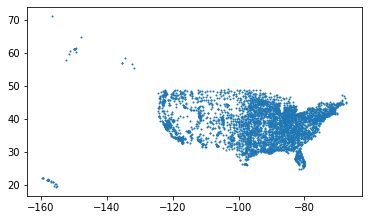

In [71]:
# Quick map of our hospitals
data.plot(markersize=1);

## Question 1: Deaths due to Serious Complications

What are the hallmarks of a hospital that sees a higher-than-average number of deaths among patients with serious treatable complications after surgery?

## Question 2: Heart Attack Readmissions

What features dictate high rates of excess readmissions for heart attacks (AKA "acute myocardial infarction or AMI), the leading cause of death for Americans?

## Question 3: How Expensive is the Care?

Do hospitals that incur greater amounts of Medicare spending per patient care event also tend to have high quality of care measures? Or perhaps is the reverse true, with more cost translating to poorer care (perhaps due to a lack of patients with private insurance to supplement Medicare, for example)? Or is the trend less obvious than either of these options suggest?

## Question 4: Would You Recommend This Hospital?

What are the common characteristics of hospitals wherein patients were most likely to say they were very likely to recommend the hospital to their friends and family?

* I'm considering this the best "overall quality" measure of the hospital that takes into account many different patients' (hopefully honest) experiences.
* One thing to note with this feature: like all of the survey response scores, it's highly positively biased (the midpoint score is somewhere around 90/100). Nothing that can't be fixed via feature scaling, but something good to note.